# Section 10: Using the ACT likelihood 

In this section we will use the pyactlike package to calculate the likelihood of a sample spectrum given the ACT data.   This package is available on [GitHub](https://github.com/ACTCollaboration/pyactlike) and was developed for Aiola et al. 2020, Choi et al. 2020. This package is based off of the Fortran implementation written by Erminia Calabrese and Jo Dunkley. 

We ask that when using these data products you reference the original work in Aiola et al. 2020 and Choi et al. 2020

To return to the main notebook or to view a different section use the links in the table of contents.


## Table of contents

 --- 
> [Section 1](Section_1_Introduction.ipynb): Introduction to AdvACT Data Release 4

> [Section 2](Section_2_coadded_maps.ipynb): S08-18 Coadded maps from [Naess et al. (2020)](https://www.overleaf.com/5395816498bsknshgxbmyr) and an Introduction to Pixell

> [Section 3](Section_3_HEALPix_CAR_Conversions.ipynb):  Demonstration of methods to convert maps between HEALPix format and the CAR format.

> [Section 4](Section_4_visualize_objects.ipynb):  Guide to using Pixell to look at objects in the maps and stacking our maps on catalogue positions.

> [Section 5](Section_5_Lensing_maps.ipynb):  Introduction to the Lensing maps from [Darwish et al](https://arxiv.org/pdf/2004.01139.pdf)

> [Section 6](Section_6_Component_separated_maps.ipynb):  Guide to the use of the Component Separated maps from [Madhavacheril et al. (2020)](https://arxiv.org/abs/1911.05717)

> [Section 7](Section_7_individual_maps_and_harmonic_analysis.ipynb): Maps of Individual Patches and Harmonic Analysis using CAR maps [Aiola et al, in preparation]

> [Section 8](Section_8_Noise_sims.ipynb): Generating Noise Simulations 

> [Section 9](Section_9_E_B_maps.ipynb):  Look at how to generate E and B maps from I, Q, U maps. 

> [Section 10](Section_10_ACT_likelihood.ipynb): Using the ACT Likelihood code
 
> [Section 11](Section_11_delensing_param_shifts.ipynb):  Delensing the CMB powerspectrum and comparing the delensed and lensed parameters from [Han et al. 2020, in preparation]
---


We begin by importing the neccessary packages, in particular the pyactlike package discussed above.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'
%run Section_1_Introduction.ipynb

import matplotlib.pyplot as plt
import numpy as np
import pyactlike
import camb

## Step 1: read in some included example spectra and plot them

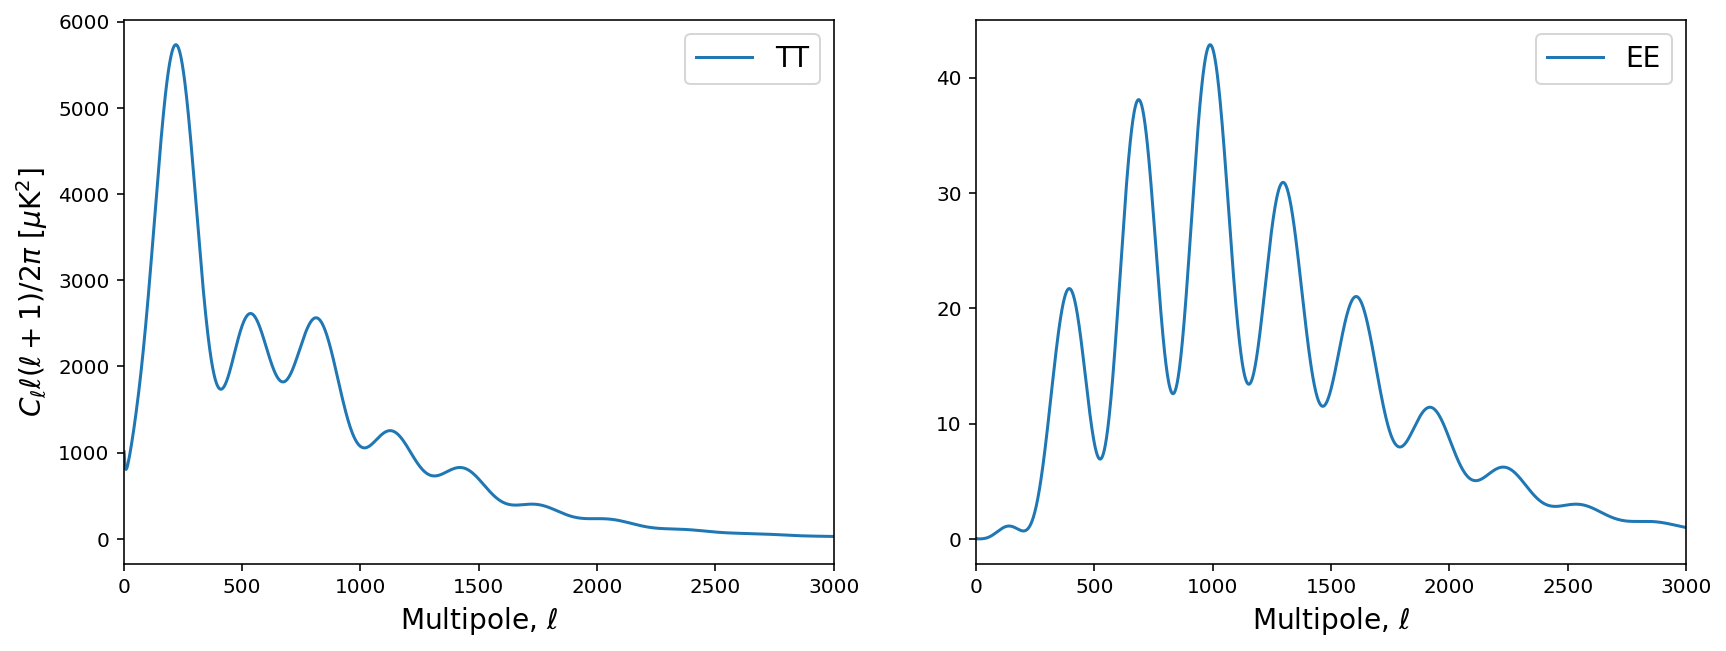

In [2]:
like = pyactlike.ACTPowerSpectrumData()

# Read an example spectrum from disk.
filename = like.data_dir + "bf_ACTPol_WMAP_lcdm.minimum.theory_cl"

tt_lmax = 6000
ell, dell_tt, dell_te, dell_ee = np.genfromtxt(
    filename,
    delimiter=None,
    unpack=True,
    max_rows=tt_lmax - 1,
    usecols=(0, 1, 2, 3),
)

# Let's quickly plot these spectra 

plt.figure(figsize = (14, 5))

plt.subplot(1,2,1)
plt.plot(ell, dell_tt, "-", label="TT")
plt.ylabel(r"$C_{\ell} \ell (\ell+1) / 2 \pi$ $[\mu$K$^2]$", fontsize = 14)
plt.xlabel(r"Multipole, $\ell$", fontsize = 14)
plt.legend(fontsize = 14)
plt.xlim(0,3000)

plt.subplot(1,2,2)
plt.plot(ell, dell_ee, "-", label="EE")
plt.xlabel(r"Multipole, $\ell$", fontsize = 14)
plt.legend(fontsize = 14)
plt.xlim(0,3000)

plt.show()

## Step 2: Compute the likelihood of the spectrum given the ACT data

In this step we also compare to the expected $\chi^2$ value and note that they match up as expected.

In [3]:
# compute the likelihood 

# now that we have the act+wmap likelihood read in we need to
# set the polarization efficiency
yp2_act_wmap = 1.003

# We can repeat this for the WMAP + ACT likelihood as follows:
like = pyactlike.ACTPowerSpectrumData()
chi2 = -2 * like.loglike(dell_tt, dell_te, dell_ee, yp2_act_wmap)
print("ACT + WMAP chi2 = " + "{0:.12f}".format(chi2))
print("Expected:         288.252869629064")

ACT + WMAP chi2 = 288.253022410716
Expected:         288.252869629064


### ACTPol only Likelihood
We can also do a similar thing using the ACTPol only likelihood.  To do so we need to adjust yp2 to 1.001 and then also read in the other likelihood.

In [4]:
# Read in the act only likelihood
filename = like.data_dir + "bf_ACTPol_lcdm.minimum.theory_cl"

tt_lmax = 6000
ell, dell_tt, dell_te, dell_ee = np.genfromtxt(
    filename,
    delimiter=None,
    unpack=True,
    max_rows=tt_lmax - 1,
    usecols=(0, 1, 2, 3),
)

# Set the new yp2 value
yp2_act_only = 1.001

# Now let's look at the chi2 using pyactlike
like = pyactlike.ACTPowerSpectrumData()
chi2 = -2 * like.loglike(dell_tt, dell_te, dell_ee, yp2_act_only)
print("ACT only chi2 = " + "{0:.12f}".format(chi2))
print("Expected:       279.004901885481")

ACT only chi2 = 279.005057627002
Expected:       279.004901885481


## Step 3: Testing an arbitrary cosmological model
Finally, we demonstrate the utility of our likelihood functionality by applying it to an arbitrary cosmological model. Theorists investigating new physics can directly compare their predicted power spectra to the data:

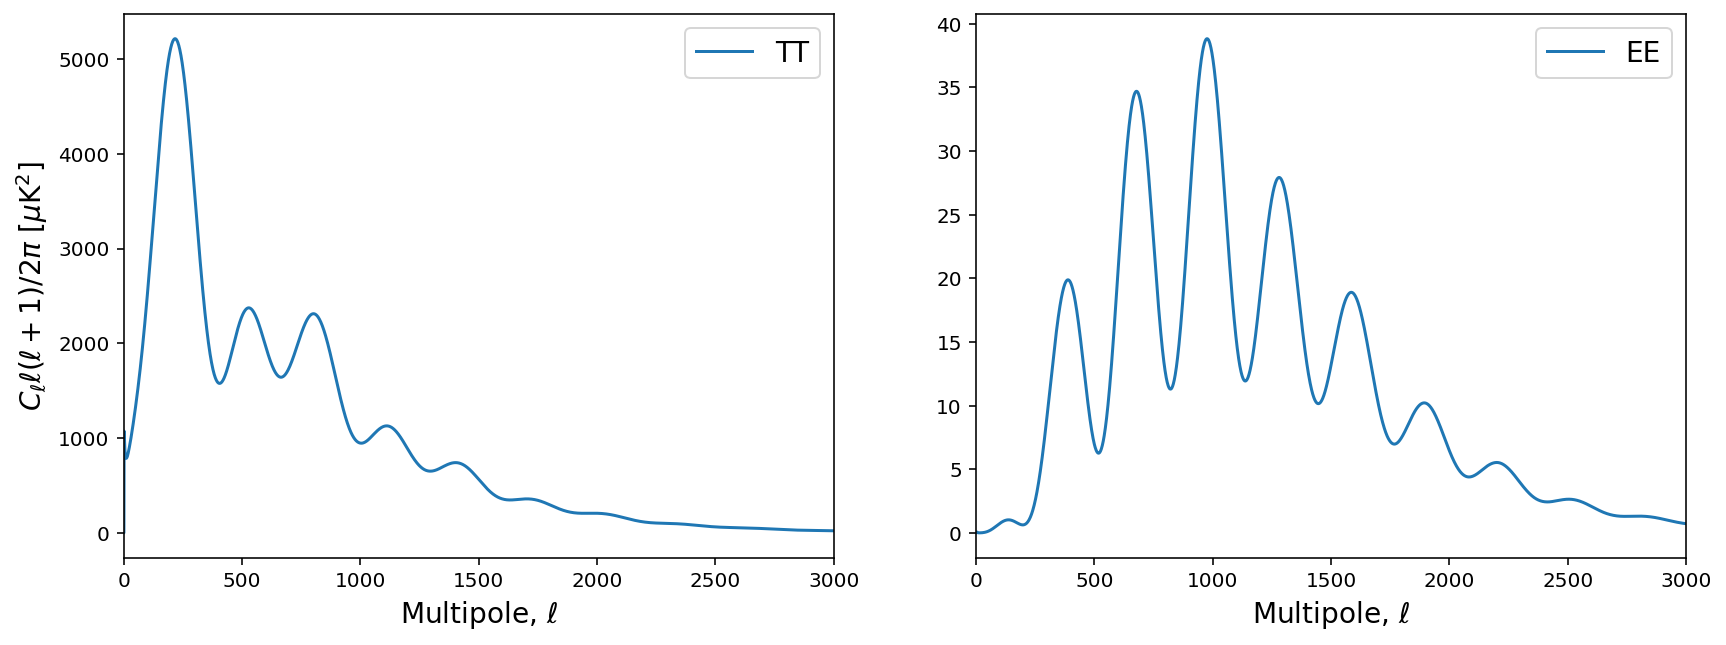

In [5]:
# first generate an arbitrary set of spectra from CAMB
cosmo_params = camb.model.CAMBparams()

# set H0 to a higher value than our best-fit result, and
# set lmax for this simulation to match ACT spectra 
cosmo_params.set_cosmology(H0 = 72)
cosmo_params.set_for_lmax(6000)

# retrieve the spectra
res = camb.get_results(cosmo_params)
spectra = res.get_cmb_power_spectra(params = cosmo_params, spectra = ('total',), CMB_unit = 'muK')['total']

# we can plot the new, theory spectra as before
ell = np.arange(spectra.shape[0])
dell_tt, dell_ee, dell_bb, dell_te = spectra.T

plt.figure(figsize = (14, 5))

plt.subplot(1,2,1)
plt.plot(ell, dell_tt, "-", label="TT")
plt.ylabel(r"$C_{\ell} \ell (\ell+1) / 2 \pi$ $[\mu$K$^2]$", fontsize = 14)
plt.xlabel(r"Multipole, $\ell$", fontsize = 14)
plt.legend(fontsize = 14)
plt.xlim(0,3000)

plt.subplot(1,2,2)
plt.plot(ell, dell_ee, "-", label="EE")
plt.xlabel(r"Multipole, $\ell$", fontsize = 14)
plt.legend(fontsize = 14)
plt.xlim(0,3000)

plt.show()

Now, get the $\chi^2$ for this universe using the ACTPol only likelihood:

In [6]:
# Look at the chi2 using pyactlike
like = pyactlike.ACTPowerSpectrumData()
chi2 = -2 * like.loglike(dell_tt, dell_te, dell_ee, yp2_act_only)
print("ACT only chi2 = " + "{0:.12f}".format(chi2))
print("Expected:       279.004901885481")

ACT only chi2 = 1128.210154271655
Expected:       279.004901885481


Thus our data highly disfavor $H_0 \sim 72 km/s/MPc$ when all other parameters are set to the *camb* defaults. Of course, any power spectra can be tested in this way, not just those parameterized by $\Lambda$-CDM.

## Step 4: Using MCMC chains generated using the ACT likelihood to look at parameters

The Likelihood we've introduced above can be used to solve for the best fit cosmological parameters that fit the ACT data.  This process and our results are discussed more in Choi et al 2020 and Aiola et al 2020 but here we will show you how to use one of the MCMC chains to look at the parameters

In [8]:
# Begin by reading in a chain and names of the columns
import pandas as pd

# Read in the column names
names = pd.read_csv(path + "ACTPol_lcdm.paramnames.csv", names = ["parameter", "latex parameter name"])
chain = np.genfromtxt(path + "ACTPol_lcdm_1.txt")
names["parameter"]

0         omegabh2
1         omegach2
2            theta
3              tau
4             logA
5               ns
6               yp
7              H0*
8          omegal*
9          omegam*
10       omegamh2*
11      omeganuh2*
12       omegamh3*
13         sigma8*
14     s8omegamp5*
15    s8omegamp25*
16           s8h5*
17     rmsdeflect*
18           zrei*
19              A*
20          clamp*
21           DL40*
22          DL220*
23          DL810*
24         DL1420*
25         DL2000*
26           ns02*
27        yheused*
28          YpBBN*
29          DHBBN*
30            age*
31          zstar*
32          rstar*
33      thetastar*
34         DAstar*
35          zdrag*
36          rdrag*
37             kd*
38         thetad*
39            zeq*
40            keq*
41        thetaeq*
42      thetarseq*
43        rsDv057*
44      Hubble057*
45          DA057*
46         FAP057*
47    fsigma8z057*
48     sigma8z057*
49    chi2_ACTPol*
50     chi2_prior*
Name: parameter, dtype: object

### Making 1D parapmeter plots and 2D contour plots
Now that we've read in the chain we cna look at the data more cloesly.  It's often useful to look at the 1D and 2D parameter plots, e.g. looking at just H0 or looking at H0 with Omega matter.

In this section we will demonstrate two ways that users can look at both of these plots.  The first is a straightforward example using matplotlib to make 1D and 2D plots for this chain.  The other option is to use Getdist which is a public software developed by Antony Lewis (Lewis 2019) specifically for looking at CMB MCMC chains.

We will start with the straightforward matplotlib example.

Text(0.5, 0, 'H0')

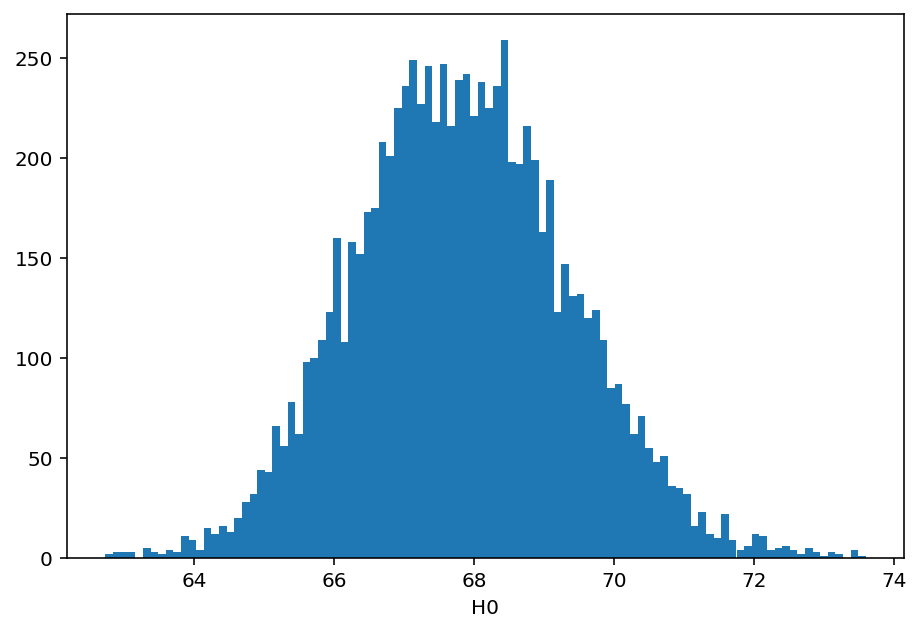

In [9]:
# We begin with the 1D plot of H0

# we use a histogram to look at the data here
plt.figure(figsize = (7.5,5))
plt.hist(chain[:,9], bins = 100)
plt.xlabel("H0")

Now let's take a look at how we can do this using getdist.  We need to start by reading in the files again using the getdist approach.

Text(0.5, 0, 'H0')

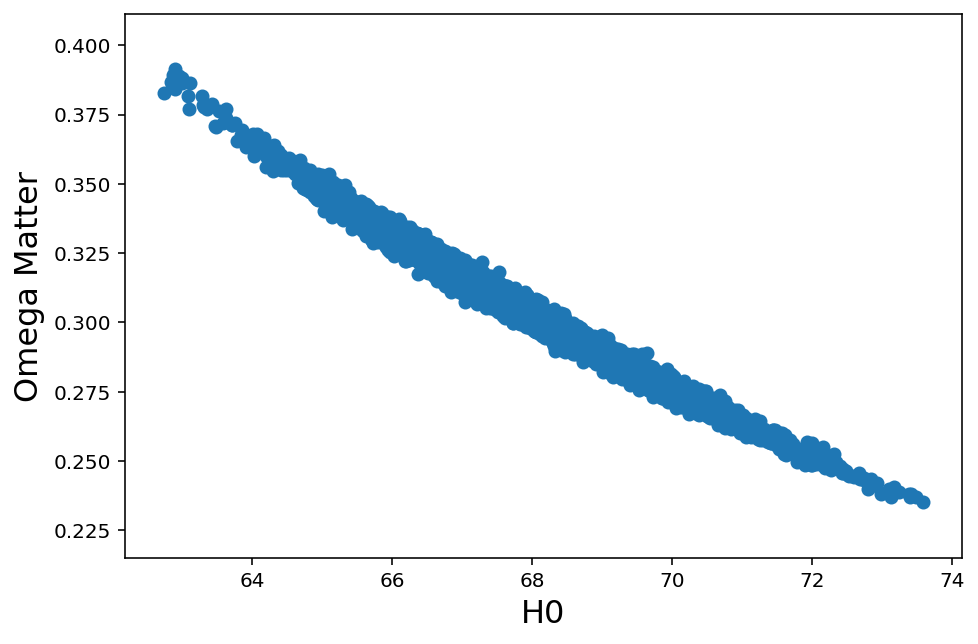

In [10]:
# Now let's try a 2D example adding in Omega Matter

# It's worth noting that since the first two columns of the chains are iteration and likelihood we add +2
# to the column number shown above when calling the columns in our scatter plot (i.e. we want H0 which is the 
# 7th parameter above so we plot chain[:, 9]) to get H0

plt.figure(figsize = (7.5, 5))
plt.scatter(chain[:,9], chain[:,11])
plt.ylabel("Omega Matter", fontsize = 16)
plt.xlabel("H0", fontsize = 16)

Let's now make the same plots using getdist.  We need to start by reading in the files again using the getdist approach.  From there we will walk through how to make the 2 plots above.

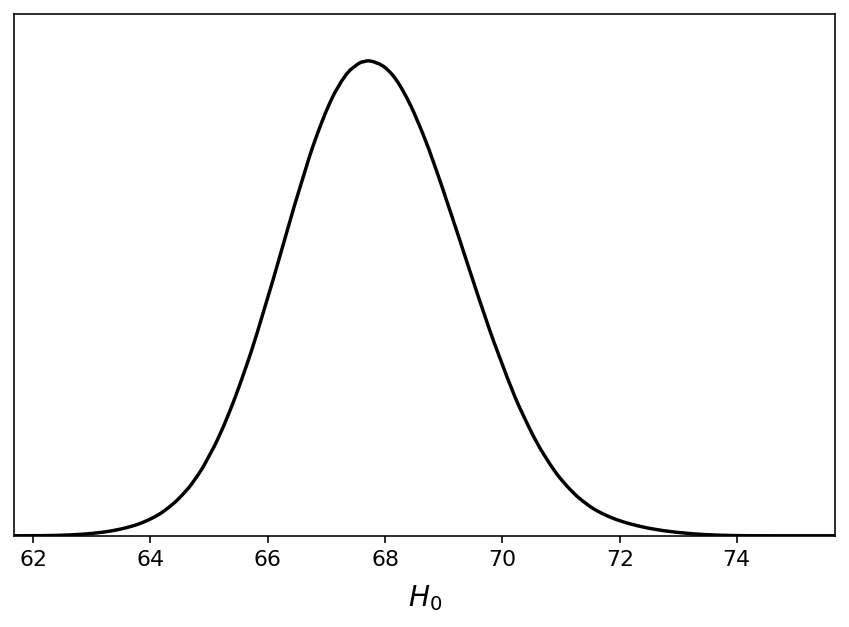

In [11]:
from getdist import loadMCSamples, plots

# Read in the samples
samples = loadMCSamples( path + 'ACTPol_lcdm', path + "ACTPol_lcdm_1.txt")

# Let's again start with the 1D version
g =plots.get_single_plotter()
g.plot_1d(samples, 'H0', marker_color='k')
plt.show()

((61.68027221163013, 75.67826446864929),
 (0.22068028430097586, 0.4208404853228044))

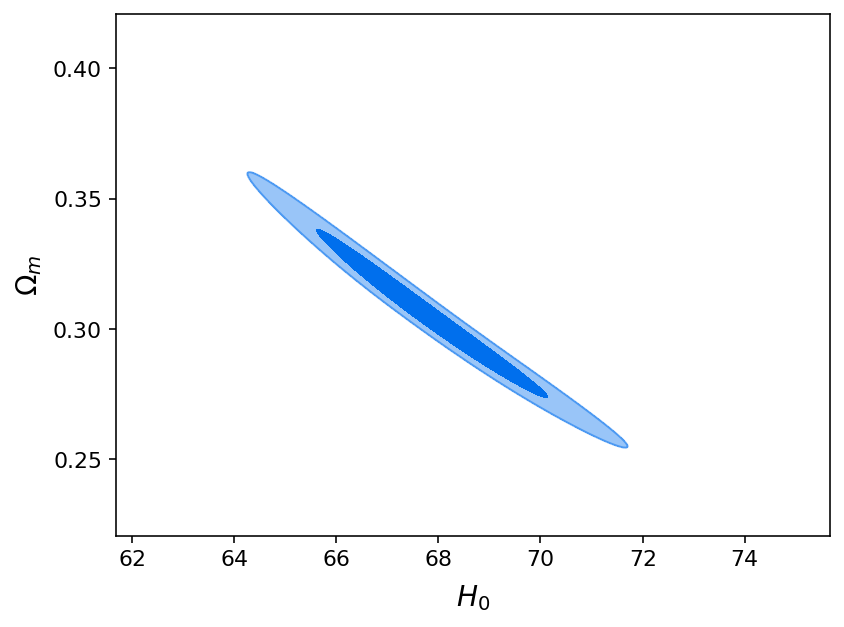

In [12]:
# We can now create a 2D contour plot using the samples we loaded above
g = plots.get_single_plotter()
g.plot_2d(samples, ['H0', 'omegam'], filled=True, )